# Occupation mobility network - Top 5 Races
Nodes represent occupations <br>
Edges represent transitions between occupations

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
import json
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
import seaborn as sns
from plottable import Table

In [2]:
#pd.set_option('display.max_rows', None)

Load the data prepared in basic_exploration

In [3]:
data_path = r'../data/cps_clean_original_races.csv'
race_occ_path = r'../data/race_codes.txt'
occ2010_data_path = r'../data/occ2010_codes.txt'

In [4]:
race_codes_df = pd.read_csv(race_occ_path, sep=';')


In [5]:
occ2010_df = pd.read_csv(occ2010_data_path, sep='                ', header=None)
occ2010_df.columns = ['OCC2010', 'occ_title']

C:\Users\jputz\AppData\Local\Temp\ipykernel_21880\1474149184.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  occ2010_df = pd.read_csv(occ2010_data_path, sep='                ', header=None)


In [6]:
occ2010_df

,OCC2010,occ_title
0,10,Chief executives and legislators/public admini...
1,20,General and Operations Managers
2,30,"Managers in Marketing, Advertising, and Public..."
3,100,Administrative Services Managers
4,110,Computer and Information Systems Managers
...,...,...
453,9800,Military Officer Special and Tactical Operatio...
454,9810,First-Line Enlisted Military Supervisors
455,9820,Military Enlisted Tactical Operations and Air/...
456,9830,"Military, Rank Not Specified"


In [7]:
occ2010_df.set_index('OCC2010').to_dict()

{'occ_title': {10: 'Chief executives and legislators/public administration',
  20: 'General and Operations Managers',
  30: 'Managers in Marketing, Advertising, and Public Relations',
  100: 'Administrative Services Managers',
  110: 'Computer and Information Systems Managers',
  120: 'Financial Managers',
  130: 'Human Resources Managers',
  140: 'Industrial Production Managers',
  150: 'Purchasing Managers',
  160: 'Transportation, Storage, and Distribution Managers',
  205: 'Farmers, Ranchers, and Other Agricultural Managers',
  220: 'Constructions Managers',
  230: 'Education Administrators',
  300: 'Architectural and Engineering Managers',
  310: 'Food Service and Lodging Managers',
  320: 'Funeral Directors',
  330: 'Gaming Managers',
  350: 'Medical and Health Services Managers',
  360: 'Natural Science Managers',
  410: 'Property, Real Estate, and Community Association Managers',
  420: 'Social and Community Service Managers',
  430: 'Managers, nec (including Postmasters)',
  5

In [8]:
# How to calculate weighted average in pandas? geeksforgeeks.org
def weighed_avg_income(df, value, weight):
    val = df[value]
    wt = df[weight]

    return (val * wt).sum() / wt.sum()

---

## 2023 for top 5 races

important note: If an occupation (e.g. 8100 for black) does not exist in OCC but in OCCLY in 2023 one would assume that in the previous year (e.g. 2022) there would be an entry where OCC is this occupation (e.g. 8100). But this is NOT true. Probably because that exact person reporting this was not interviewed in the previous year.

In [9]:
def create_graph(race: int, year: int, save: bool = True) -> nx.Graph:
    last_year = year-1
    data_df = pd.read_csv(data_path, sep=';')

    data_r = data_df[data_df['RACE'] == race]
    data_23 = data_r[data_r['YEAR'] == year]

    data_23 = data_23[['OCC2010', 'OCC10LY', 'Category', 'ASECWT', 'INCWAGE']]
    data_23['OCC2010'] = data_23['OCC2010'].astype('int64')
    data_23['OCC10LY'] = data_23['OCC10LY'].astype('int64')

    # calculate avg income per occupation in 2023
    #average_wages_df = data_23.groupby('OCC2010')['INCWAGE'].mean().reset_index()
    #average_wages_df.columns = ['OCC2010', 'Average_INCWAGE']
    
    # calculate avg income per occupation in 2022 (for OCCLY that are not transitioned to)
    #average_wages_LY = data_r[data_r['YEAR'] == last_year].groupby('OCC2010')['INCWAGE'].mean().reset_index()
    #average_wages_LY.columns = ['OCC2010', 'Average_INCWAGE']


    average_wages_df = data_23[data_23['OCC2010'] == data_23['OCC10LY']].groupby('OCC2010').apply(weighed_avg_income, 'INCWAGE', 'ASECWT').reset_index()
    average_wages_df.columns = ['OCC2010', 'Average_INCWAGE']

    scaler = MinMaxScaler()
    average_wages_df['Average_INCWAGE_scaled'] = scaler.fit_transform(average_wages_df['Average_INCWAGE'].values.reshape(-1, 1))

    data_23 = data_23.groupby(['OCC2010', 'OCC10LY', 'Category'])['ASECWT'].sum().reset_index()
    data_23 = data_23.merge(average_wages_df, on='OCC2010')

    #average_wages_df.set_index('OCC2010', inplace=True)
    #average_wages_LY.set_index('OCC2010', inplace=True) 
    #average_wages_df = average_wages_df.combine_first(average_wages_LY)
    #average_wages_df.reset_index(inplace=True)

    # Get unique categories
    unique_categories = data_23['Category'].unique()

    # Create a dictionary to map categories to codes
    category_to_code = {category: code for code, category in enumerate(unique_categories)}

    # Add a new column with category codes
    data_23['category_code'] = data_23['Category'].map(category_to_code)

    G = nx.from_pandas_edgelist(data_23, source='OCC10LY', target='OCC2010', edge_attr=['ASECWT'], create_using=nx.DiGraph())

    # make sure every node gets assigned correct category code
    occ10_cat = data_23[['OCC2010', 'category_code']].drop_duplicates()
    occly10_cat = data_23[['OCC10LY', 'category_code']].drop_duplicates()

    occ10_cat.columns = ['OCC', 'category_code']
    occly10_cat.columns = ['OCC', 'category_code']

    merged_df = occ10_cat.merge(occly10_cat, on=['OCC', 'category_code'], how='outer')
    merged_df = merged_df.drop_duplicates(subset=['OCC'])
    merged_df = merged_df.merge(average_wages_df, left_on='OCC', right_on='OCC2010',  how='left')
    merged_df.drop('OCC2010', axis=1,  inplace=True)

    merged_df['Average_INCWAGE'] = merged_df['Average_INCWAGE'].fillna(0)
    node_attr = merged_df.set_index('OCC').to_dict('index')
    print(node_attr)

    # set occupation category and income as node attributes
    nx.set_node_attributes(G, node_attr)

    # remove selfloops
    G.remove_edges_from(nx.selfloop_edges(G))

    if save:
        mapping = occ2010_df.set_index('OCC2010').to_dict()
        H = nx.relabel_nodes(G, mapping.get('occ_title'))
        nx.write_gexf(H,f"./networks/network_{race}_{year}.gexf")

    return G

In [10]:
def plot_graph(G: nx.Graph, race: int):
    ## Compute a layout
    pos = nx.kamada_kawai_layout(G,
                                #weight="ASECWT",
                                scale=2)

    ## Fix a node ordering
    nodelist = G.nodes
    ## Convert classes labels to numbers for plotting
    colors = [G.nodes[ni]["category_code"] for ni in nodelist]
    size = [G.nodes[node]['Average_INCWAGE_scaled']*500 for node in list(G.nodes)]

    plt.figure(figsize=(16, 13))
    nx.draw_networkx(G,
                    pos=pos,
                    #node_size=size,
                    font_size=7,
                    width=0.1, ## Edge width
                    #nodelist=nodelist, 
                    node_color=colors,
                    cmap="rainbow",
                    with_labels=True,
                    #labels={ni:G.nodes[ni]["category"] for ni in nodelist}, ## Label each node (student) with the class she attends
                    font_color="k"
                    )
    
    category_codes = set(colors)
    normalizer = matplotlib.colors.Normalize(0, len(category_codes))
    legend_labels = {code: f'Category {code}' for code in category_codes}
    handles = [plt.Line2D([], [], marker='o', linestyle='', color=plt.cm.rainbow(normalizer(i)), markersize=10, label=label) for i, label in enumerate(legend_labels.values())]
    plt.legend(handles=handles, title='Category Code', loc='upper right', bbox_to_anchor=(1.1, 0.9))

    race_title = race_codes_df[race_codes_df['RACE'] == race]['race_title'].values[0]
    plt.title(f'{race_title} 2023')
    plt.axis("off")
    plt.show()

In [11]:
def calc_centrality_measures(G: nx.Graph, max_iter: int = None) -> pd.DataFrame:
    # degree centrality
    centrality = pd.DataFrame(nx.degree_centrality(G).items(), 
                                          columns=['OCC2010', 'degree'])
    centrality_df = occ2010_df.merge(centrality, how='right', on='OCC2010')

    # weighted degree centrality
    # source: https://www.kaggle.com/code/rahulgoel1106/network-centrality-using-networkx
    degree = G.degree(weight='ASECWT')
    max_degree = max(dict(degree).values())
    degree_centrality_w = [(k, deg/max_degree) for k, deg in dict(degree).items()]
    weighed_degree_centrality = pd.DataFrame.from_dict(degree_centrality_w)
    weighed_degree_centrality.columns=['OCC2010', 'weighted_degree']

    centrality_df = centrality_df.merge(weighed_degree_centrality, on='OCC2010')

    # weighted in degree centrality
    in_degree = G.in_degree(weight = 'ASECWT')
    max_in_degree = max(dict(in_degree).values())
    in_degree_centrality_w = [(k, deg/max_in_degree) for k, deg in dict(in_degree).items()]
    weighed_in_degree_centrality = pd.DataFrame.from_dict(in_degree_centrality_w)
    weighed_in_degree_centrality.columns = ['OCC2010', 'weighed_in_degree']

    centrality_df = centrality_df.merge(weighed_in_degree_centrality, on='OCC2010')

    # weighted out degree centrality
    out_degree = G.out_degree(weight = 'ASECWT')
    max_out_degree = max(dict(out_degree).values())
    out_degree_centrality_w = [(k, deg/max_out_degree) for k, deg in dict(out_degree).items()]
    weighed_out_degree_centrality = pd.DataFrame.from_dict(out_degree_centrality_w)
    weighed_out_degree_centrality.columns = ['OCC2010', 'weighed_out_degree']

    centrality_df = centrality_df.merge(weighed_out_degree_centrality, on='OCC2010')

    # betweenness centrality
    betweenness_centrality = pd.DataFrame(nx.betweenness_centrality(G).items(), 
                                          columns=['OCC2010', 'betweenness'])
    centrality_df = centrality_df.merge(betweenness_centrality, on='OCC2010')

    # closeness centrality
    closeness_centrality = pd.DataFrame(nx.closeness_centrality(G).items(), 
                                          columns=['OCC2010', 'closeness'])
    centrality_df = centrality_df.merge(closeness_centrality, on='OCC2010')

    # eigen-centrality
    if max_iter:
        eigen_centrality = pd.DataFrame(nx.eigenvector_centrality(G, max_iter=max_iter).items(), 
                                          columns=['OCC2010', 'eigenvector'])
    else:
        eigen_centrality = pd.DataFrame(nx.eigenvector_centrality(G).items(), 
                                          columns=['OCC2010', 'eigenvector'])
    centrality_df = centrality_df.merge(eigen_centrality, on='OCC2010')

    # PageRank
    pagerank = pd.DataFrame(nx.pagerank(G, weight='ASECWT').items(), 
                                          columns=['OCC2010', 'pagerank'])
    centrality_df = centrality_df.merge(pagerank, on='OCC2010')


    return centrality_df

In [12]:
def top_centrality(centralities: pd.DataFrame, amount: int, centrality: str):
    top = centralities.nlargest(amount, centrality)
    return top['occ_title'].values

In [13]:
def get_top_occ_centralities(centralities: pd.DataFrame, amount: int = 5) -> pd.DataFrame:
    top_centralities = pd.DataFrame(columns=['degree', 'weighed_in_degree', 'weighed_out_degree', 'betweenness', 'closeness', 'eigenvector', 'pagerank'])
    
    top_centralities['degree'] = top_centrality(centralities, amount, 'degree')
    top_centralities['weighed_in_degree'] = top_centrality(centralities, amount, 'weighed_in_degree')
    top_centralities['weighed_out_degree'] = top_centrality(centralities, amount, 'weighed_out_degree')

    top_centralities['betweenness'] = top_centrality(centralities, amount, 'betweenness')
    top_centralities['closeness'] = top_centrality(centralities, amount, 'closeness')
    top_centralities['eigenvector'] = top_centrality(centralities, amount, 'eigenvector')
    top_centralities['pagerank'] = top_centrality(centralities, amount, 'pagerank')

    return top_centralities

In [14]:
def combine_centrality_income(race: int, centrality_df: pd.DataFrame, year: int = 2023) -> pd.DataFrame:
    data_df = pd.read_csv(data_path, sep=';')

    data = data_df[data_df['YEAR'] == year]
    data = data[data['RACE'] == race]

    data = data[['OCC2010', 'INCWAGE', 'ASECWT', 'OCC10LY']]

    # calculate avg income per occupation
    data = data[data['OCC2010'] == data['OCC10LY']]
    data = data.groupby(['OCC2010']).apply(weighed_avg_income, 'INCWAGE', 'ASECWT').reset_index()
    data.columns = ['OCC2010', 'Average_INCWAGE']

    # merge with centrality measures
    centrality_wage = data.merge(centrality_df, on='OCC2010')

    return centrality_wage

#### White


In [15]:
data_df = pd.read_csv(data_path, sep=';')

data_23 = data_df[data_df['YEAR'] == 2023]
data_23 = data_23[data_23['RACE'] == 100]


data_23 = data_23[['OCC2010', 'OCC10LY', 'Category', 'ASECWT', 'INCWAGE']]

# calculate avg income per occupation in 2023
data_23 = data_23[data_23['OCC2010'] == data_23['OCC10LY']]
average_wages_df = data_23.groupby(['OCC2010']).apply(weighed_avg_income, 'INCWAGE', 'ASECWT').reset_index()
average_wages_df.columns = ['OCC2010', 'Average_INCWAGE']
scaler = MinMaxScaler()
average_wages_df['Average_INCWAGE_scaled'] = scaler.fit_transform(average_wages_df['Average_INCWAGE'].values.reshape(-1, 1))
data_23 = data_23.groupby(['OCC2010', 'OCC10LY', 'Category'])['ASECWT'].sum().reset_index()
data_23 = data_23.merge(average_wages_df, on='OCC2010')

{10: {'category_code': 0, 'Average_INCWAGE': 184725.53083632083, 'Average_INCWAGE_scaled': 0.7939009876620379}, 20: {'category_code': 0, 'Average_INCWAGE': 113305.51792972635, 'Average_INCWAGE_scaled': 0.4869568498989627}, 30: {'category_code': 0, 'Average_INCWAGE': 124485.91372188287, 'Average_INCWAGE_scaled': 0.535007204507013}, 100: {'category_code': 0, 'Average_INCWAGE': 77779.58758658341, 'Average_INCWAGE_scaled': 0.33427589096846905}, 110: {'category_code': 0, 'Average_INCWAGE': 148936.93307217804, 'Average_INCWAGE_scaled': 0.6400911543197922}, 120: {'category_code': 0, 'Average_INCWAGE': 152416.11358358563, 'Average_INCWAGE_scaled': 0.6550437427993372}, 130: {'category_code': 0, 'Average_INCWAGE': 109043.96121490929, 'Average_INCWAGE_scaled': 0.46864181748544725}, 140: {'category_code': 0, 'Average_INCWAGE': 110356.83468581029, 'Average_INCWAGE_scaled': 0.4742841969686987}, 150: {'category_code': 0, 'Average_INCWAGE': 91315.9201067705, 'Average_INCWAGE_scaled': 0.392451432315920

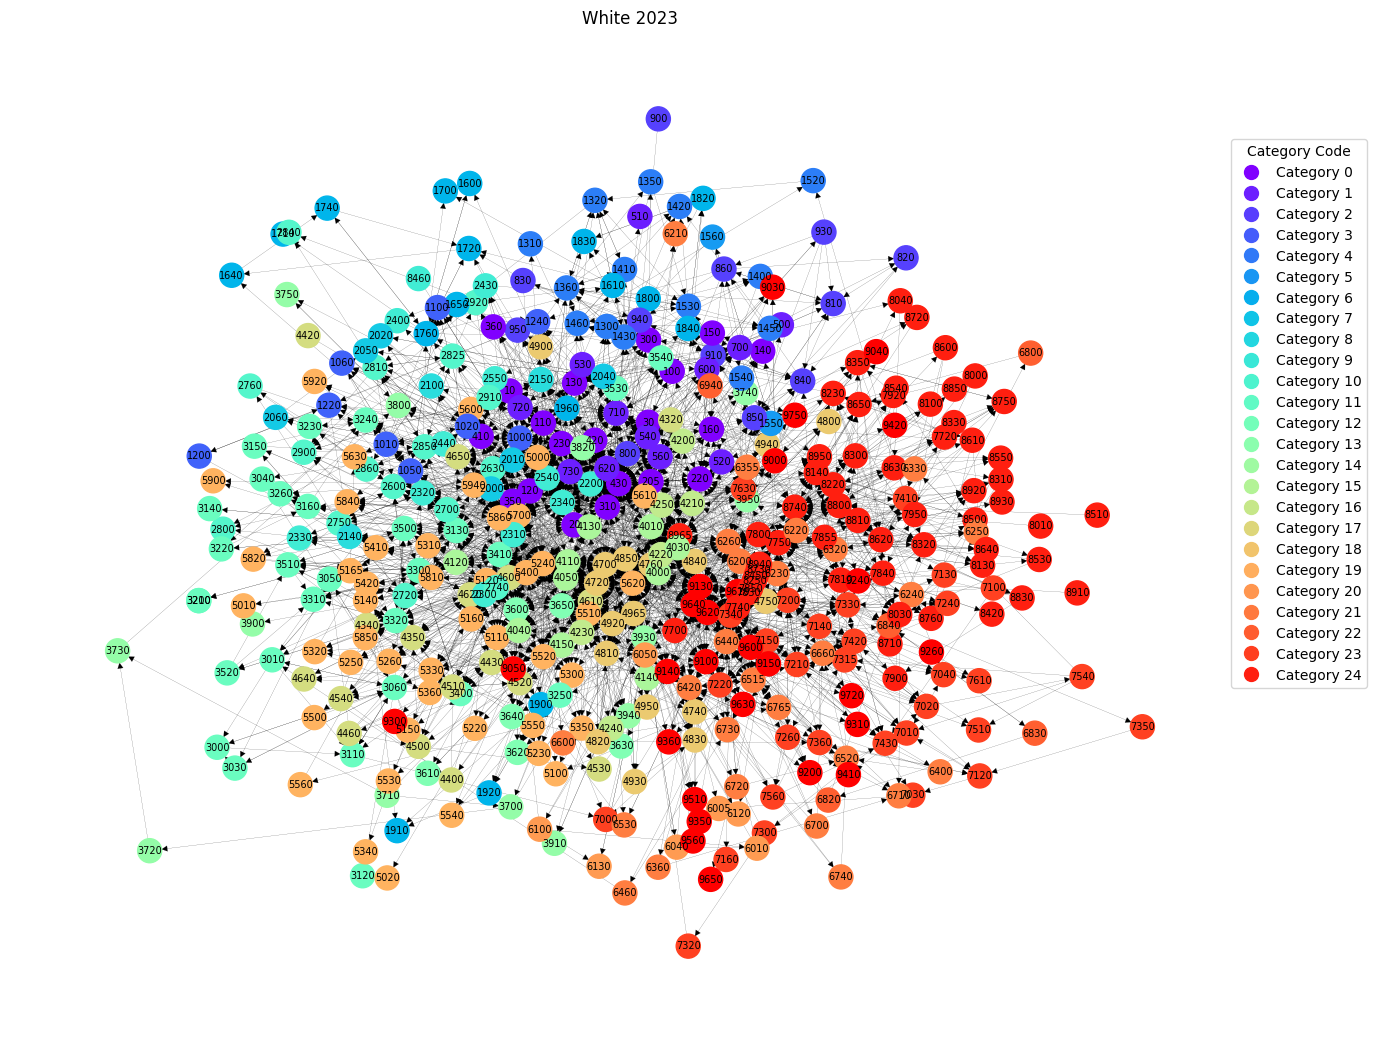

In [16]:
G_100 = create_graph(100, 2023)
plot_graph(G_100, 100)

In [17]:
centrality_100 = calc_centrality_measures(G_100)

In [18]:
top_centralities_100 = get_top_occ_centralities(centrality_100)
top_centralities_100

,degree,weighed_in_degree,weighed_out_degree,betweenness,closeness,eigenvector,pagerank
0,"Managers, nec (including Postmasters)","Managers, nec (including Postmasters)","Managers, nec (including Postmasters)","Managers, nec (including Postmasters)","Managers, nec (including Postmasters)","Managers, nec (including Postmasters)","Managers, nec (including Postmasters)"
1,Customer Service Representatives,Retail Salespersons,Retail Salespersons,Customer Service Representatives,Customer Service Representatives,Customer Service Representatives,Computer Scientists and Systems Analysts/Netwo...
2,Retail Salespersons,Cashiers,Customer Service Representatives,"Assemblers and Fabricators, nec",First-Line Supervisors of Sales Workers,First-Line Supervisors of Sales Workers,Retail Salespersons
3,Cashiers,Driver/Sales Workers and Truck Drivers,Cashiers,Retail Salespersons,Retail Salespersons,Cashiers,Customer Service Representatives
4,"Assemblers and Fabricators, nec",Customer Service Representatives,Driver/Sales Workers and Truck Drivers,Driver/Sales Workers and Truck Drivers,Driver/Sales Workers and Truck Drivers,Retail Salespersons,Driver/Sales Workers and Truck Drivers


In [19]:
centrality_wage_100 = combine_centrality_income(100, centrality_100)
centrality_wage_100

,OCC2010,Average_INCWAGE,occ_title,degree,weighted_degree,weighed_in_degree,weighed_out_degree,betweenness,closeness,eigenvector,pagerank
0,10.0,184725.530836,Chief executives and legislators/public admini...,0.052632,0.205965,0.198757,0.212019,0.002932,0.299043,0.032768,0.004198
1,20.0,113305.517930,General and Operations Managers,0.090909,0.267563,0.330568,0.214648,0.012862,0.360582,0.098546,0.005651
2,30.0,124485.913722,"Managers in Marketing, Advertising, and Public...",0.064593,0.242152,0.279855,0.210488,0.004230,0.321015,0.046466,0.004527
3,100.0,77779.587587,Administrative Services Managers,0.026316,0.055847,0.068538,0.045188,0.000376,0.313828,0.035595,0.001465
4,110.0,148936.933072,Computer and Information Systems Managers,0.047847,0.133990,0.080925,0.178556,0.002373,0.299043,0.024351,0.001648
...,...,...,...,...,...,...,...,...,...,...,...
413,9630.0,26146.894849,Machine Feeders and Offbearers,0.019139,0.021031,0.014177,0.026788,0.000259,0.299043,0.024260,0.000626
414,9640.0,30122.931799,"Packers and Packagers, Hand",0.074163,0.231907,0.236561,0.227999,0.007549,0.342590,0.072945,0.004145
415,9650.0,61843.316382,Pumping Station Operators,0.002392,0.002605,0.005706,0.000000,0.000000,0.237015,0.002101,0.000596
416,9720.0,24467.022108,Refuse and Recyclable Material Collectors,0.014354,0.016298,0.017755,0.015074,0.000014,0.286562,0.017580,0.000698


lowest average income: Furniture Finishers (0.00 $)<br>
highest average income: Podiatrists (331,333.33 $)<br>
Most popular/central occupation is Managers. They have the highest weighed in degree but also highest weighed out degree. Also the highest betweenness, pagerank and eigenvector centrality as well as a very high closeness.

In [20]:
centrality_wage_100.sort_values(by='weighed_out_degree')

,OCC2010,Average_INCWAGE,occ_title,degree,weighted_degree,weighed_in_degree,weighed_out_degree,betweenness,closeness,eigenvector,pagerank
239,5340.0,31993.470770,New Account Clerks,0.002392,0.007048,0.015440,0.000000,0.000000,0.226537,2.110448e-03,0.000577
103,2440.0,45088.730083,Library Technicians,0.007177,0.003886,0.008512,0.000000,0.000000,0.316685,3.786428e-02,0.000715
345,7920.0,57453.956581,"Extruding and Drawing Machine Setters, Operato...",0.007177,0.020391,0.044671,0.000000,0.000000,0.280681,1.338140e-02,0.001163
388,8940.0,52000.000000,Tire Builders,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.665508e-19,0.000417
273,6210.0,75633.702802,Boilermakers,0.004785,0.007375,0.016157,0.000000,0.000000,0.251465,5.259956e-03,0.000614
...,...,...,...,...,...,...,...,...,...,...,...
396,9130.0,54103.873806,Driver/Sales Workers and Truck Drivers,0.181818,0.557340,0.518433,0.590016,0.048643,0.384045,1.411944e-01,0.010997
204,4720.0,22626.282978,Cashiers,0.198565,0.611155,0.625833,0.598828,0.041930,0.379710,1.689304e-01,0.009474
232,5240.0,54443.211245,Customer Service Representatives,0.263158,0.615212,0.516583,0.698043,0.076959,0.404842,2.135029e-01,0.011430
207,4760.0,46478.334283,Retail Salespersons,0.224880,0.732459,0.635882,0.813568,0.057763,0.385807,1.673973e-01,0.011690


<Axes: >

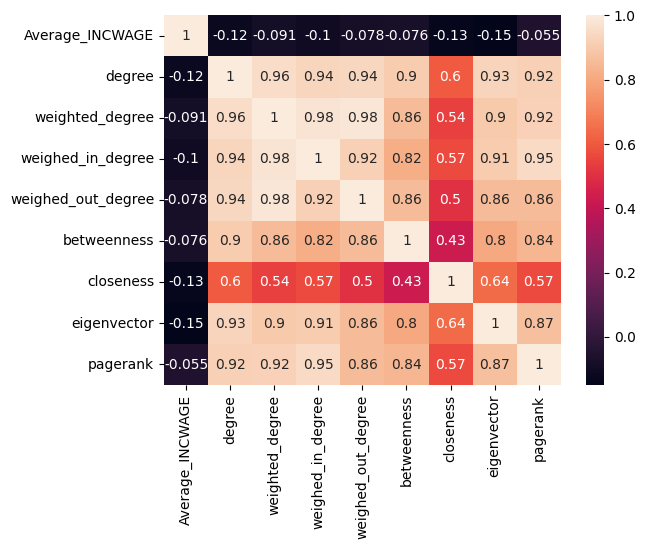

In [21]:
corr = centrality_wage_100[['Average_INCWAGE', 'degree', 'weighted_degree', 'weighed_in_degree', 'weighed_out_degree', 'betweenness', 'closeness', 'eigenvector', 'pagerank']].corr()
sns.heatmap(corr, annot=True)

In [23]:
white_overall = data_df[data_df['RACE'] == 100]
white_overall[(white_overall['OCC2010'] == 430.0) & (white_overall['OCC10LY'] == 430.0)]

,YEAR,SERIAL,CPSID,ASECFLAG,PERNUM,ASECWT,AGE,SEX,RACE,ASIAN,...,OCCLY,OCC10LY,INCWAGE,MIGSTA1,WHYMOVE,MIGRATE1,Category,occ_title,race_comp_all,race_comp_2003
1,1968,35,NaN,NaN,1,1268.58,60,1,100,NaN,...,290.0,430.0,10000,NaN,NaN,1.0,"MANAGEMENT, BUSINESS, SCIENCE, AND ARTS","Managers, nec (including Postmasters)",100,100
2,1968,44,NaN,NaN,1,1230.62,25,1,100,NaN,...,290.0,430.0,7100,NaN,NaN,1.0,"MANAGEMENT, BUSINESS, SCIENCE, AND ARTS","Managers, nec (including Postmasters)",100,100
3,1968,61,NaN,NaN,1,1343.78,62,1,100,NaN,...,290.0,430.0,30000,NaN,NaN,1.0,"MANAGEMENT, BUSINESS, SCIENCE, AND ARTS","Managers, nec (including Postmasters)",100,100
4,1968,62,NaN,NaN,1,1346.78,34,1,100,NaN,...,290.0,430.0,12000,NaN,NaN,1.0,"MANAGEMENT, BUSINESS, SCIENCE, AND ARTS","Managers, nec (including Postmasters)",100,100
5,1968,63,NaN,NaN,1,1440.05,45,1,100,NaN,...,290.0,430.0,15000,NaN,NaN,5.0,"MANAGEMENT, BUSINESS, SCIENCE, AND ARTS","Managers, nec (including Postmasters)",100,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214005,2023,87975,0.000000e+00,1.0,2,598.16,41,1,100,99.0,...,335.0,430.0,0,99.0,0.0,1.0,"MANAGEMENT, BUSINESS, SCIENCE, AND ARTS","Managers, nec (including Postmasters)",100,100
214006,2023,87997,0.000000e+00,1.0,1,472.89,61,1,100,99.0,...,440.0,430.0,190000,99.0,0.0,1.0,"MANAGEMENT, BUSINESS, SCIENCE, AND ARTS","Managers, nec (including Postmasters)",100,100
214009,2023,88046,2.022030e+13,1.0,1,933.56,55,1,100,99.0,...,440.0,430.0,175000,99.0,0.0,1.0,"MANAGEMENT, BUSINESS, SCIENCE, AND ARTS","Managers, nec (including Postmasters)",100,100
214011,2023,88150,2.022030e+13,1.0,3,755.57,57,1,100,99.0,...,440.0,430.0,80000,99.0,0.0,1.0,"MANAGEMENT, BUSINESS, SCIENCE, AND ARTS","Managers, nec (including Postmasters)",100,100


#### Black

{10: {'category_code': 0, 'Average_INCWAGE': 130991.58516949741, 'Average_INCWAGE_scaled': 0.37313489152286416}, 20: {'category_code': 0, 'Average_INCWAGE': 81453.07694692556, 'Average_INCWAGE_scaled': 0.23202242335999962}, 30: {'category_code': 0, 'Average_INCWAGE': 79467.28172647938, 'Average_INCWAGE_scaled': 0.22636580440078155}, 100: {'category_code': 0, 'Average_INCWAGE': 40385.41259308512, 'Average_INCWAGE_scaled': 0.11503950064828998}, 110: {'category_code': 0, 'Average_INCWAGE': 135321.09142302355, 'Average_INCWAGE_scaled': 0.3854676672822128}, 120: {'category_code': 0, 'Average_INCWAGE': 89265.32849074899, 'Average_INCWAGE_scaled': 0.25427594161906925}, 130: {'category_code': 0, 'Average_INCWAGE': 101720.70725987163, 'Average_INCWAGE_scaled': 0.2897555978113281}, 140: {'category_code': 0, 'Average_INCWAGE': 77740.85289167371, 'Average_INCWAGE_scaled': 0.22144800120629693}, 150: {'category_code': 0, 'Average_INCWAGE': 87436.39458460633, 'Average_INCWAGE_scaled': 0.2490661485335

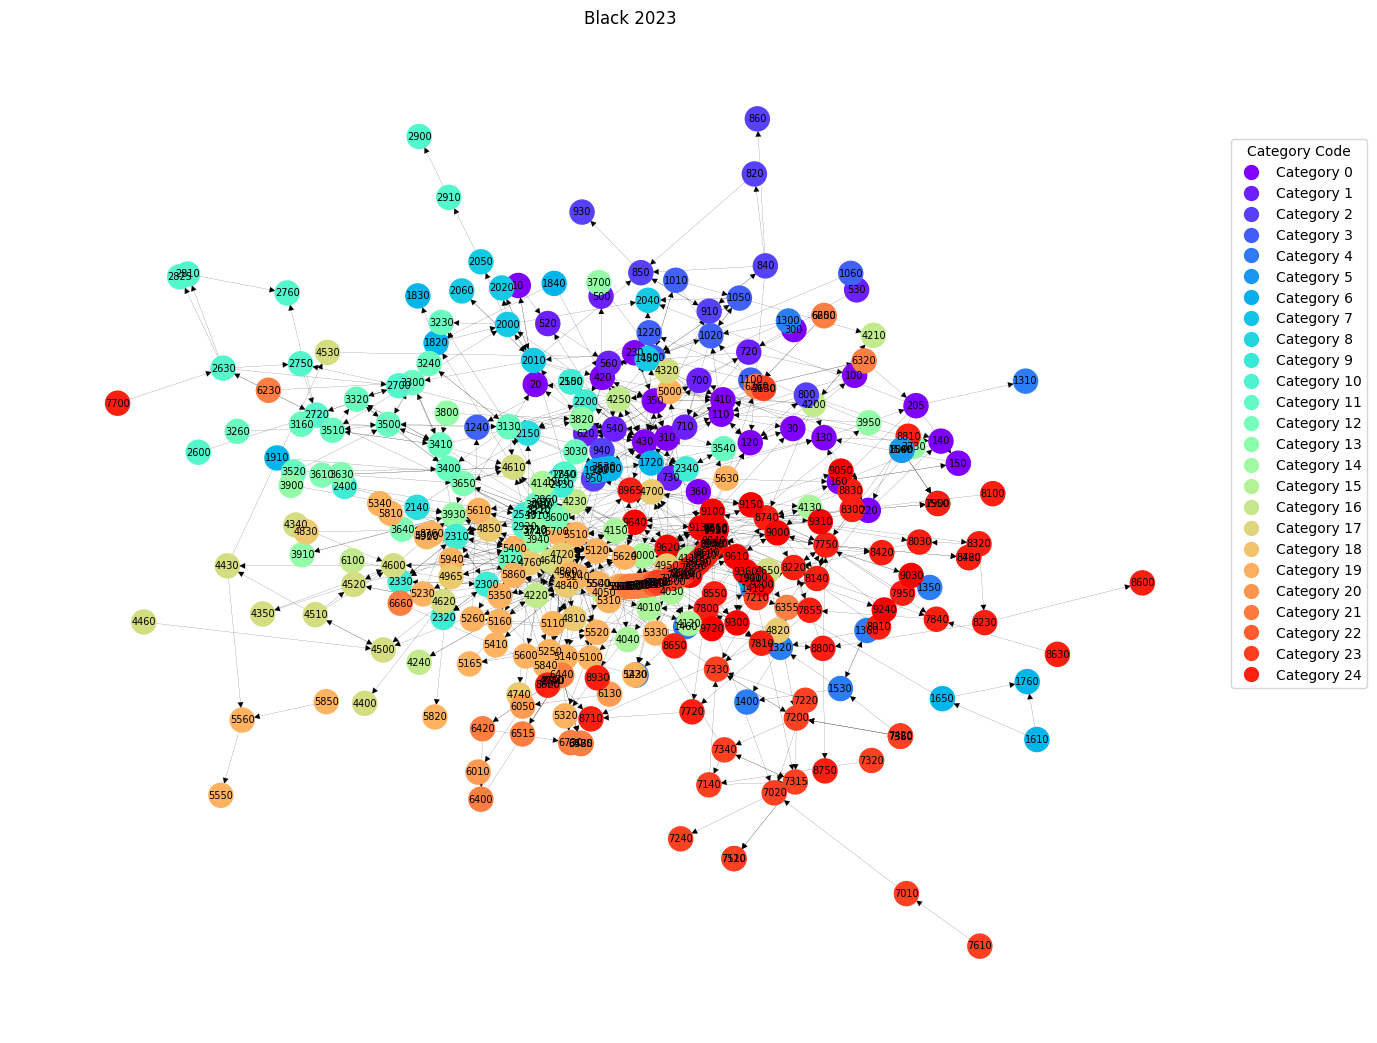

In [24]:
G_200 = create_graph(200, 2023)
plot_graph(G_200, 200)

In [25]:
centrality_200 = calc_centrality_measures(G_200)

In [28]:
top_centralities_200 = get_top_occ_centralities(centrality_200)
top_centralities_200

,degree,weighed_in_degree,weighed_out_degree,betweenness,closeness,eigenvector,pagerank
0,"Managers, nec (including Postmasters)","Managers, nec (including Postmasters)","Laborers and Freight, Stock, and Material Move...","Managers, nec (including Postmasters)","Managers, nec (including Postmasters)","Managers, nec (including Postmasters)","Managers, nec (including Postmasters)"
1,Customer Service Representatives,"Nursing, Psychiatric, and Home Health Aides","Managers, nec (including Postmasters)",Customer Service Representatives,First-Line Supervisors of Sales Workers,Customer Service Representatives,"Nursing, Psychiatric, and Home Health Aides"
2,"Laborers and Freight, Stock, and Material Move...",Driver/Sales Workers and Truck Drivers,"Nursing, Psychiatric, and Home Health Aides","Laborers and Freight, Stock, and Material Move...",Couriers and Messengers,Driver/Sales Workers and Truck Drivers,Customer Service Representatives
3,Driver/Sales Workers and Truck Drivers,Personal Care Aides,Customer Service Representatives,Driver/Sales Workers and Truck Drivers,"Human Resources, Training, and Labor Relations...",Stock Clerks and Order Fillers,Driver/Sales Workers and Truck Drivers
4,Cashiers,Customer Service Representatives,Driver/Sales Workers and Truck Drivers,"Nursing, Psychiatric, and Home Health Aides",Bus and Ambulance Drivers and Attendants,"Laborers and Freight, Stock, and Material Move...",Elementary and Middle School Teachers


In [29]:
centrality_wage_200 = combine_centrality_income(200, centrality_200)
centrality_wage_200

,OCC2010,Average_INCWAGE,occ_title,degree,weighted_degree,weighed_in_degree,weighed_out_degree,betweenness,closeness,eigenvector,pagerank
0,10.0,130991.585169,Chief executives and legislators/public admini...,0.008427,0.027613,0.034137,0.019664,0.000427,0.127216,0.004340,0.002986
1,20.0,81453.076947,General and Operations Managers,0.019663,0.097392,0.130717,0.059224,0.003402,0.160193,0.027730,0.004692
2,30.0,79467.281726,"Managers in Marketing, Advertising, and Public...",0.014045,0.083817,0.087302,0.075709,0.003364,0.158496,0.056339,0.005154
3,100.0,40385.412593,Administrative Services Managers,0.011236,0.021488,0.031787,0.010175,0.000218,0.131052,0.010581,0.002417
4,110.0,135321.091423,Computer and Information Systems Managers,0.022472,0.062979,0.070808,0.051770,0.004542,0.172942,0.073717,0.003550
...,...,...,...,...,...,...,...,...,...,...,...
335,9600.0,40784.358235,Industrial Truck and Tractor Operators,0.039326,0.244984,0.211369,0.264297,0.007693,0.170967,0.165321,0.004469
336,9610.0,24473.442065,Cleaners of Vehicles and Equipment,0.030899,0.190921,0.262169,0.110288,0.003155,0.166529,0.158256,0.003963
337,9620.0,33079.672348,"Laborers and Freight, Stock, and Material Move...",0.092697,0.818912,0.587869,1.000000,0.047216,0.177266,0.229091,0.011056
338,9640.0,38960.782122,"Packers and Packagers, Hand",0.042135,0.368963,0.314514,0.401802,0.007660,0.165506,0.156278,0.004941


* lowest average income: Glaziers (0.00 $)
* highest average income: Dentists (330,400.00 $)
Transitioning to Managers is very popular. Where Laborers and Freight, Stock, and Material Movers is most central when it comes to leaving this occupation.

In [30]:
centrality_wage_200.sort_values(by = 'weighed_in_degree')

,OCC2010,Average_INCWAGE,occ_title,degree,weighted_degree,weighed_in_degree,weighed_out_degree,betweenness,closeness,eigenvector,pagerank
87,2430.0,44974.817172,Librarians,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.817342e-26,0.000729
132,3720.0,70000.000000,First-Line Supervisors of Fire Fighting and Pr...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.817342e-26,0.000729
266,7320.0,49512.245142,Home Appliance Repairers,0.002809,0.001627,0.000000,0.003133,0.000000,0.000000,4.817342e-26,0.000729
269,7350.0,64000.000000,"Maintenance Workers, Machinery",0.002809,0.005690,0.000000,0.010958,0.000000,0.000000,4.817342e-26,0.000729
270,7360.0,60955.422723,Millwrights,0.002809,0.015548,0.000000,0.029947,0.000000,0.000000,4.817342e-26,0.000729
...,...,...,...,...,...,...,...,...,...,...,...
198,5240.0,38516.895912,Customer Service Representatives,0.112360,0.751197,0.705457,0.754117,0.062972,0.185058,2.589198e-01,0.020673
168,4610.0,29586.044919,Personal Care Aides,0.036517,0.549748,0.736936,0.335210,0.017423,0.181322,9.146395e-02,0.016039
322,9130.0,54551.283894,Driver/Sales Workers and Truck Drivers,0.078652,0.741574,0.785955,0.656539,0.042520,0.180110,2.529408e-01,0.018218
125,3600.0,33881.026624,"Nursing, Psychiatric, and Home Health Aides",0.058989,0.848007,0.786922,0.860582,0.041196,0.183046,1.207394e-01,0.022072


<Axes: >

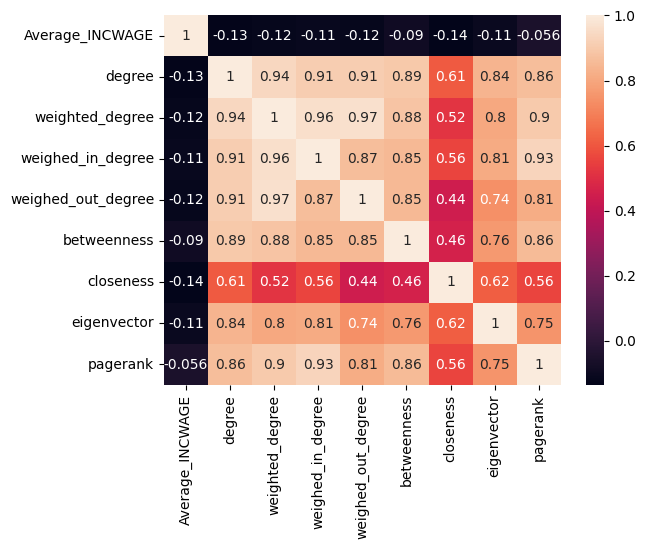

In [31]:
corr = centrality_wage_200[['Average_INCWAGE', 'degree', 'weighted_degree','weighed_in_degree', 'weighed_out_degree', 'betweenness', 'closeness', 'eigenvector', 'pagerank']].corr()
sns.heatmap(corr, annot=True)

#### American Indian/Aleut/Eskimo

{10: {'category_code': 0, 'Average_INCWAGE': 62190.987937679194, 'Average_INCWAGE_scaled': 0.12438197587535839}, 20: {'category_code': 0, 'Average_INCWAGE': 55577.31965658002, 'Average_INCWAGE_scaled': 0.11115463931316003}, 30: {'category_code': 0, 'Average_INCWAGE': 54996.2614076743, 'Average_INCWAGE_scaled': 0.10999252281534859}, 100: {'category_code': 0, 'Average_INCWAGE': 165588.41551951633, 'Average_INCWAGE_scaled': 0.33117683103903267}, 110: {'category_code': 0, 'Average_INCWAGE': 100000.0, 'Average_INCWAGE_scaled': 0.19999999999999998}, 120: {'category_code': 0, 'Average_INCWAGE': 88311.27334350527, 'Average_INCWAGE_scaled': 0.17662254668701052}, 130: {'category_code': 0, 'Average_INCWAGE': 132995.40015954417, 'Average_INCWAGE_scaled': 0.26599080031908834}, 150: {'category_code': 0, 'Average_INCWAGE': 50000.0, 'Average_INCWAGE_scaled': 0.09999999999999999}, 160: {'category_code': 0, 'Average_INCWAGE': 90747.90928797337, 'Average_INCWAGE_scaled': 0.1814958185759467}, 205: {'categ

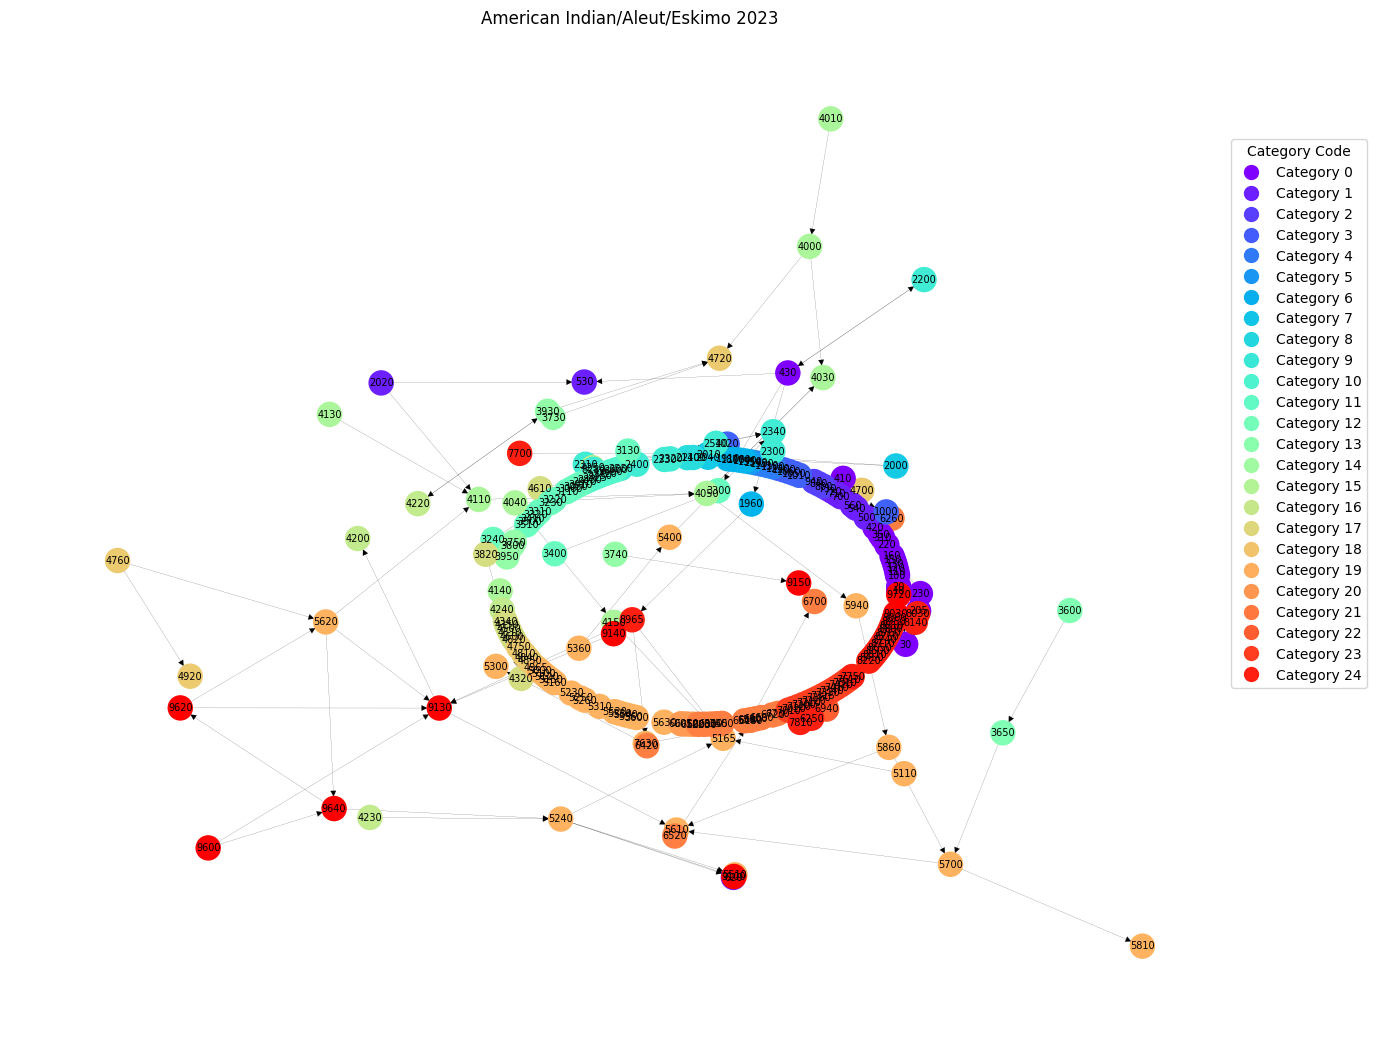

In [32]:
G_300 = create_graph(300, 2023)
plot_graph(G_300, 300)

In [33]:
centrality_300 = calc_centrality_measures(G_300, max_iter = 500)

In [34]:
top_centralities_300 = get_top_occ_centralities(centrality_300)
top_centralities_300

,degree,weighed_in_degree,weighed_out_degree,betweenness,closeness,eigenvector,pagerank
0,Driver/Sales Workers and Truck Drivers,Stock Clerks and Order Fillers,Retail Salespersons,"Combined Food Preparation and Serving Workers,...","Shipping, Receiving, and Traffic Clerks","Shipping, Receiving, and Traffic Clerks","Shipping, Receiving, and Traffic Clerks"
1,Customer Service Representatives,"Financial Clerks, nec",Other production workers including semiconduct...,"Office and administrative support workers, nec","Financial Clerks, nec","Combined Food Preparation and Serving Workers,...","Combined Food Preparation and Serving Workers,..."
2,"Managers, nec (including Postmasters)",Waiters and Waitresses,Customer Service Representatives,Waiters and Waitresses,Driver/Sales Workers and Truck Drivers,Food Preparation Workers,"Office Clerks, General"
3,"Combined Food Preparation and Serving Workers,...",Clinical Laboratory Technologists and Technicians,Bartenders,Stock Clerks and Order Fillers,"Combined Food Preparation and Serving Workers,...","Office and administrative support workers, nec","Office and administrative support workers, nec"
4,Stock Clerks and Order Fillers,"Host and Hostesses, Restaurant, Lounge, and Co...",Counselors,"Office Clerks, General",First-Line Supervisors of Housekeeping and Jan...,"Office Clerks, General",Secretaries and Administrative Assistants


In [35]:
centrality_wage_300 = combine_centrality_income(300, centrality_300)
centrality_wage_300

,OCC2010,Average_INCWAGE,occ_title,degree,weighted_degree,weighed_in_degree,weighed_out_degree,betweenness,closeness,eigenvector,pagerank
0,10.0,62190.987938,Chief executives and legislators/public admini...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.455090e-117,0.003362
1,20.0,55577.319657,General and Operations Managers,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.455090e-117,0.003362
2,30.0,54996.261408,"Managers in Marketing, Advertising, and Public...",0.004651,0.031316,0.048562,0.000000,0.000000,0.004651,2.440024e-114,0.006220
3,100.0,165588.415520,Administrative Services Managers,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.455090e-117,0.003362
4,110.0,100000.000000,Computer and Information Systems Managers,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.455090e-117,0.003362
...,...,...,...,...,...,...,...,...,...,...,...
201,9150.0,35567.633164,"Motor Vehicle Operators, All Other",0.004651,0.083628,0.129683,0.000000,0.000000,0.004651,2.440024e-114,0.006220
202,9600.0,35000.000000,Industrial Truck and Tractor Operators,0.009302,0.387296,0.000000,0.653318,0.000000,0.000000,6.455090e-117,0.003362
203,9620.0,36813.694278,"Laborers and Freight, Stock, and Material Move...",0.013953,0.311860,0.040116,0.482428,0.000413,0.009302,3.311765e-03,0.005458
204,9640.0,27133.547842,"Packers and Packagers, Hand",0.018605,0.470236,0.598026,0.142691,0.000674,0.012403,3.311765e-03,0.008063


* lowest average income: Photographers, Musicians, Roofers, ... (0.00 $)
* highest average income: Economists and Market researchers (50,000.00 $)
Very popular occupation to transition to are Stock Clerks and Order Fillers. Very common to leave is the occupation Retail Salespersons. 

In [36]:
centrality_wage_300.sort_values(by = 'weighed_in_degree')

,OCC2010,Average_INCWAGE,occ_title,degree,weighted_degree,weighed_in_degree,weighed_out_degree,betweenness,closeness,eigenvector,pagerank
0,10.0,62190.987938,Chief executives and legislators/public admini...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.455090e-117,0.003362
122,5120.0,45396.463745,"Bookkeeping, Accounting, and Auditing Clerks",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.455090e-117,0.003362
123,5150.0,75000.000000,Procurement Clerks,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.455090e-117,0.003362
124,5160.0,27565.252404,Bank Tellers,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.455090e-117,0.003362
126,5230.0,40000.000000,"Credit Authorizers, Checkers, and Clerks",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.455090e-117,0.003362
...,...,...,...,...,...,...,...,...,...,...,...
97,4150.0,24784.676203,"Host and Hostesses, Restaurant, Lounge, and Co...",0.009302,0.646715,0.627477,0.408350,0.000022,0.004651,2.440024e-114,0.005981
74,3300.0,52000.000000,Clinical Laboratory Technologists and Technicians,0.009302,0.425974,0.660562,0.000000,0.000000,0.010465,1.987059e-03,0.006838
94,4110.0,25141.625549,Waiters and Waitresses,0.018605,0.507510,0.716828,0.076333,0.000956,0.016279,3.311765e-03,0.012069
125,5165.0,28433.212365,"Financial Clerks, nec",0.018605,0.490046,0.759919,0.000000,0.000000,0.027625,5.298823e-03,0.014362


<Axes: >

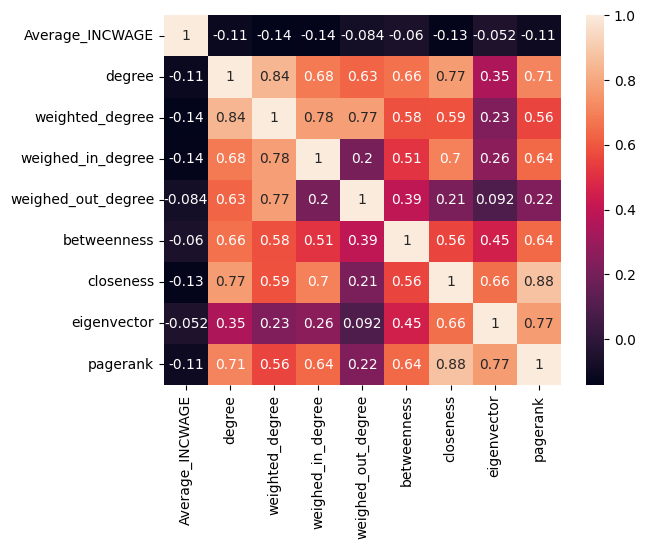

In [37]:
corr = centrality_wage_300[['Average_INCWAGE', 'degree', 'weighted_degree','weighed_in_degree', 'weighed_out_degree', 'betweenness', 'closeness', 'eigenvector', 'pagerank']].corr()
sns.heatmap(corr, annot=True)

#### White-Black

{10: {'category_code': 0, 'Average_INCWAGE': 87115.0234484812, 'Average_INCWAGE_scaled': 0.3871778819932497}, 20: {'category_code': 0, 'Average_INCWAGE': 65623.20742308072, 'Average_INCWAGE_scaled': 0.2916586996581365}, 30: {'category_code': 0, 'Average_INCWAGE': 54212.18042510705, 'Average_INCWAGE_scaled': 0.24094302411158688}, 100: {'category_code': 0, 'Average_INCWAGE': 72000.0, 'Average_INCWAGE_scaled': 0.31999999999999995}, 110: {'category_code': 0, 'Average_INCWAGE': 225000.0, 'Average_INCWAGE_scaled': 0.9999999999999999}, 120: {'category_code': 0, 'Average_INCWAGE': 50026.69687449343, 'Average_INCWAGE_scaled': 0.22234087499774854}, 130: {'category_code': 0, 'Average_INCWAGE': 38000.0, 'Average_INCWAGE_scaled': 0.16888888888888887}, 220: {'category_code': 0, 'Average_INCWAGE': 221014.06544477795, 'Average_INCWAGE_scaled': 0.9822847353101242}, 230: {'category_code': 0, 'Average_INCWAGE': 34051.920909839864, 'Average_INCWAGE_scaled': 0.1513418707103994}, 310: {'category_code': 0, '

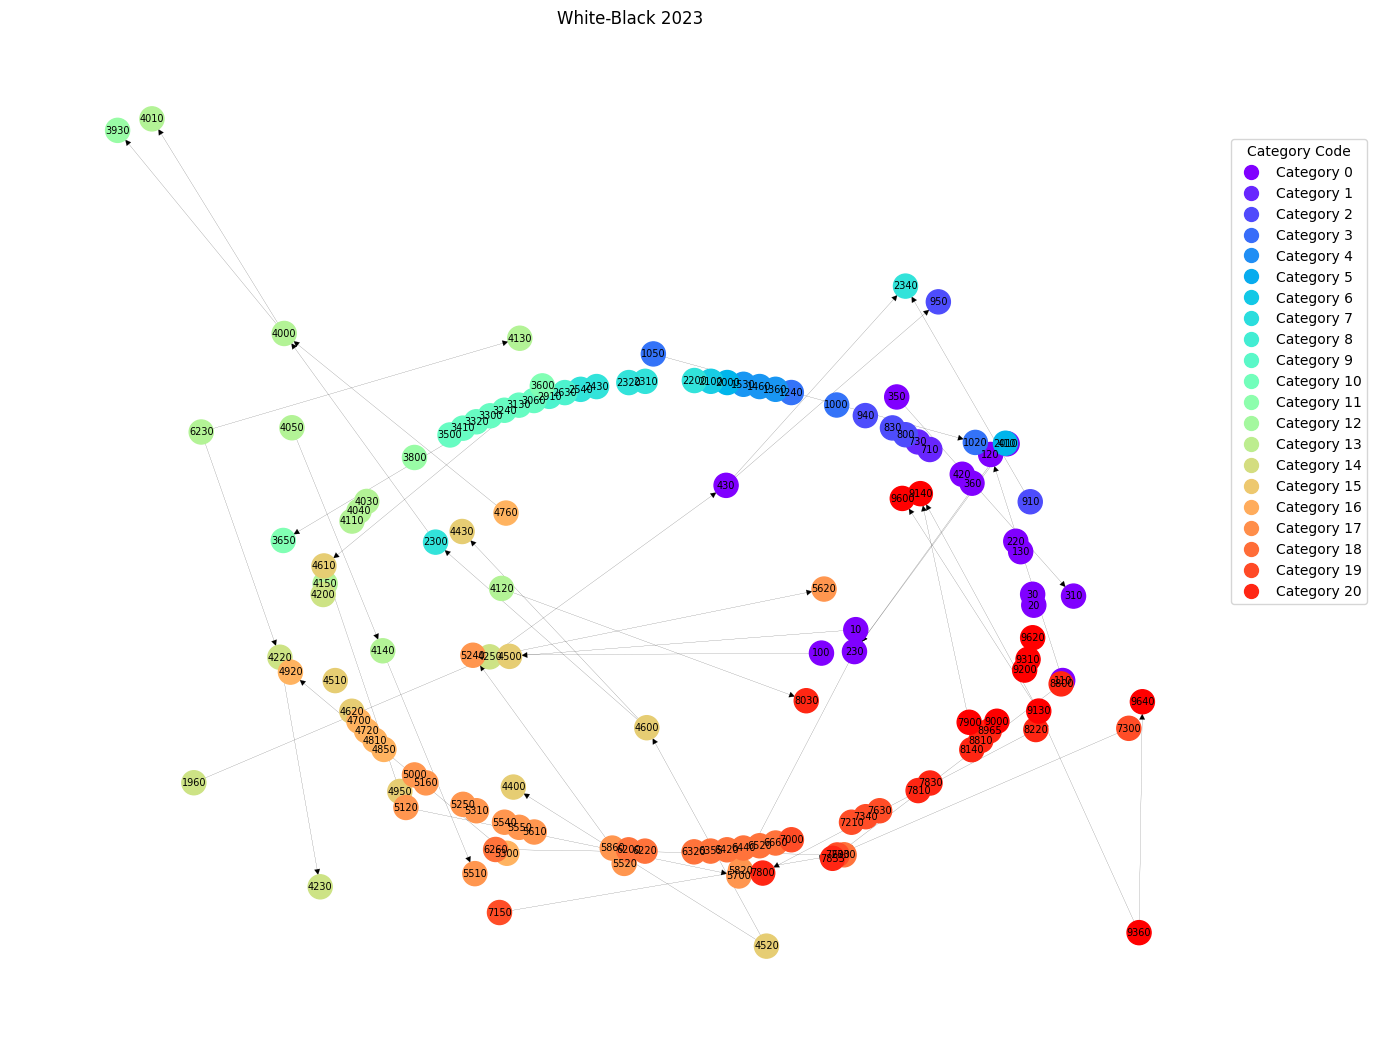

In [38]:
G_801 = create_graph(801, 2023)
plot_graph(G_801, 801)

In [43]:
centrality_801 = calc_centrality_measures(G_801, max_iter=500)

In [44]:
top_centralities_801 = get_top_occ_centralities(centrality_801)
top_centralities_801

,degree,weighed_in_degree,weighed_out_degree,betweenness,closeness,eigenvector,pagerank
0,Chefs and Cooks,"Food Processing, nec",Packaging and Filling Machine Operators and Te...,Chefs and Cooks,Other Teachers and Instructors,Security Guards and Gaming Surveillance Officers,Chefs and Cooks
1,Education Administrators,Taxi Drivers and Chauffeurs,Grounds Maintenance Workers,Preschool and Kindergarten Teachers,Chefs and Cooks,First-Line Supervisors of Food Preparation and...,Word Processors and Typists
2,"Managers, nec (including Postmasters)",Word Processors and Typists,Childcare Workers,Childcare Workers,Taxi Drivers and Chauffeurs,Other Teachers and Instructors,Security Guards and Gaming Surveillance Officers
3,Grounds Maintenance Workers,Preschool and Kindergarten Teachers,"Nursing, Psychiatric, and Home Health Aides","Managers, nec (including Postmasters)",Security Guards and Gaming Surveillance Officers,Chefs and Cooks,Education Administrators
4,Childcare Workers,Grounds Maintenance Workers,Automotive and Watercraft Service Attendants,Grounds Maintenance Workers,First-Line Supervisors of Food Preparation and...,"Financial Specialists, nec",Customer Service Representatives


In [ ]:
centrality_wage_801 = combine_centrality_income(801, centrality_801)
centrality_wage_801

,OCC2010,Average_INCWAGE,occ_title,degree,weighted_degree,weighed_in_degree,weighed_out_degree,betweenness,closeness,eigenvector,pagerank
0,10.0,87115.023448,Chief executives and legislators/public admini...,0.006211,0.153496,0.000000,0.205097,0.0,0.000000,1.646361e-10,0.004232
1,20.0,65623.207423,General and Operations Managers,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.646361e-10,0.004232
2,30.0,54212.180425,"Managers in Marketing, Advertising, and Public...",0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.646361e-10,0.004232
3,100.0,72000.000000,Administrative Services Managers,0.006211,0.168983,0.000000,0.225789,0.0,0.000000,1.646361e-10,0.004232
4,110.0,225000.000000,Computer and Information Systems Managers,0.006211,0.241023,0.000000,0.322048,0.0,0.000000,1.646361e-10,0.004232
...,...,...,...,...,...,...,...,...,...,...,...
117,9200.0,80000.000000,Locomotive Engineers and Operators,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.646361e-10,0.004232
118,9310.0,150000.000000,Ship and Boat Captains and Operators,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.646361e-10,0.004232
119,9600.0,35229.211544,Industrial Truck and Tractor Operators,0.006211,0.227886,0.364314,0.000000,0.0,0.008282,8.709251e-08,0.006030
120,9620.0,24672.481071,"Laborers and Freight, Stock, and Material Move...",0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.646361e-10,0.004232


* lowest average income: First-Line Supervisors of Construction Trades...; Other Installation... (0.00 $)
* highest average income: Bakers (564,039.5 $)

In [ ]:
centrality_wage_801[centrality_wage_801['OCC2010'] == 430.0]

,OCC2010,Average_INCWAGE,occ_title,degree,weighted_degree,weighed_in_degree,weighed_out_degree,betweenness,closeness,eigenvector,pagerank
14,430.0,87825.0,"Managers, nec (including Postmasters)",0.018634,0.391996,0.245389,0.318676,0.000155,0.008282,8.709251e-08,0.006155


In [ ]:
centrality_wage_801.sort_values(by='weighed_in_degree')

,OCC2010,Average_INCWAGE,occ_title,degree,weighted_degree,weighed_in_degree,weighed_out_degree,betweenness,closeness,eigenvector,pagerank
0,10.0,87115.023448,Chief executives and legislators/public admini...,0.006211,0.153496,0.000000,0.205097,0.000000,0.000000,1.646361e-10,0.004232
84,5540.0,32000.000000,Postal Service Clerks,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.646361e-10,0.004232
82,5310.0,57173.462999,"Interviewers, Except Eligibility and Loan",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.646361e-10,0.004232
81,5250.0,54000.000000,"Eligibility Interviewers, Government Programs",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.646361e-10,0.004232
79,5160.0,7200.000000,Bank Tellers,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.646361e-10,0.004232
...,...,...,...,...,...,...,...,...,...,...,...
64,4250.0,39392.750658,Grounds Maintenance Workers,0.018634,0.926230,0.631667,0.709651,0.000155,0.006211,5.432992e-09,0.007829
33,2300.0,50000.000000,Preschool and Kindergarten Teachers,0.012422,0.477722,0.637251,0.105700,0.000466,0.009317,9.036877e-07,0.009365
89,5820.0,30002.000000,Word Processors and Typists,0.006211,0.405604,0.648424,0.000000,0.000000,0.011180,1.687520e-07,0.013946
116,9140.0,80000.000000,Taxi Drivers and Chauffeurs,0.012422,0.419181,0.670131,0.000000,0.000000,0.013975,9.236087e-08,0.008700


<Axes: >

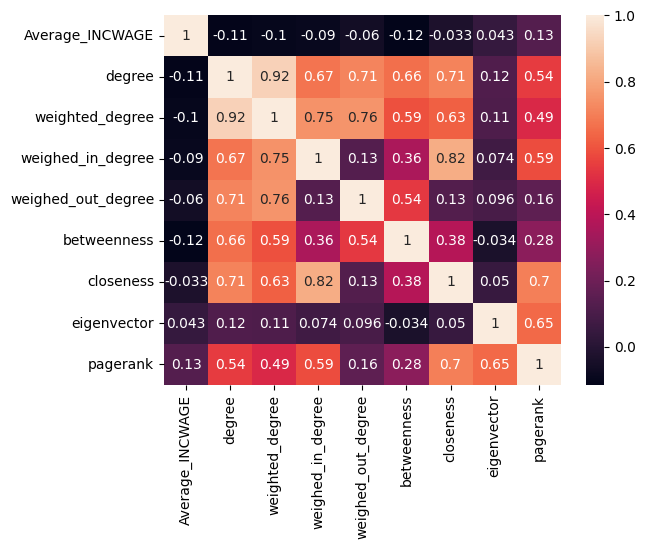

In [ ]:
corr = centrality_wage_801[['Average_INCWAGE', 'degree', 'weighted_degree','weighed_in_degree', 'weighed_out_degree', 'betweenness', 'closeness', 'eigenvector', 'pagerank']].corr()
sns.heatmap(corr, annot=True)

### Asian only

{10: {'category_code': 0, 'Average_INCWAGE': 183269.33604700633, 'Average_INCWAGE_scaled': 0.45817334011751587}, 20: {'category_code': 0, 'Average_INCWAGE': 131750.10651910683, 'Average_INCWAGE_scaled': 0.3293752662977671}, 30: {'category_code': 0, 'Average_INCWAGE': 128470.45135946134, 'Average_INCWAGE_scaled': 0.3211761283986534}, 100: {'category_code': 0, 'Average_INCWAGE': 60204.31114434854, 'Average_INCWAGE_scaled': 0.15051077786087136}, 110: {'category_code': 0, 'Average_INCWAGE': 140729.5832536144, 'Average_INCWAGE_scaled': 0.35182395813403605}, 120: {'category_code': 0, 'Average_INCWAGE': 171169.96807446532, 'Average_INCWAGE_scaled': 0.42792492018616335}, 130: {'category_code': 0, 'Average_INCWAGE': 152306.2614142456, 'Average_INCWAGE_scaled': 0.380765653535614}, 140: {'category_code': 0, 'Average_INCWAGE': 119225.17730299328, 'Average_INCWAGE_scaled': 0.2980629432574832}, 150: {'category_code': 0, 'Average_INCWAGE': 83010.46392353575, 'Average_INCWAGE_scaled': 0.20752615980883

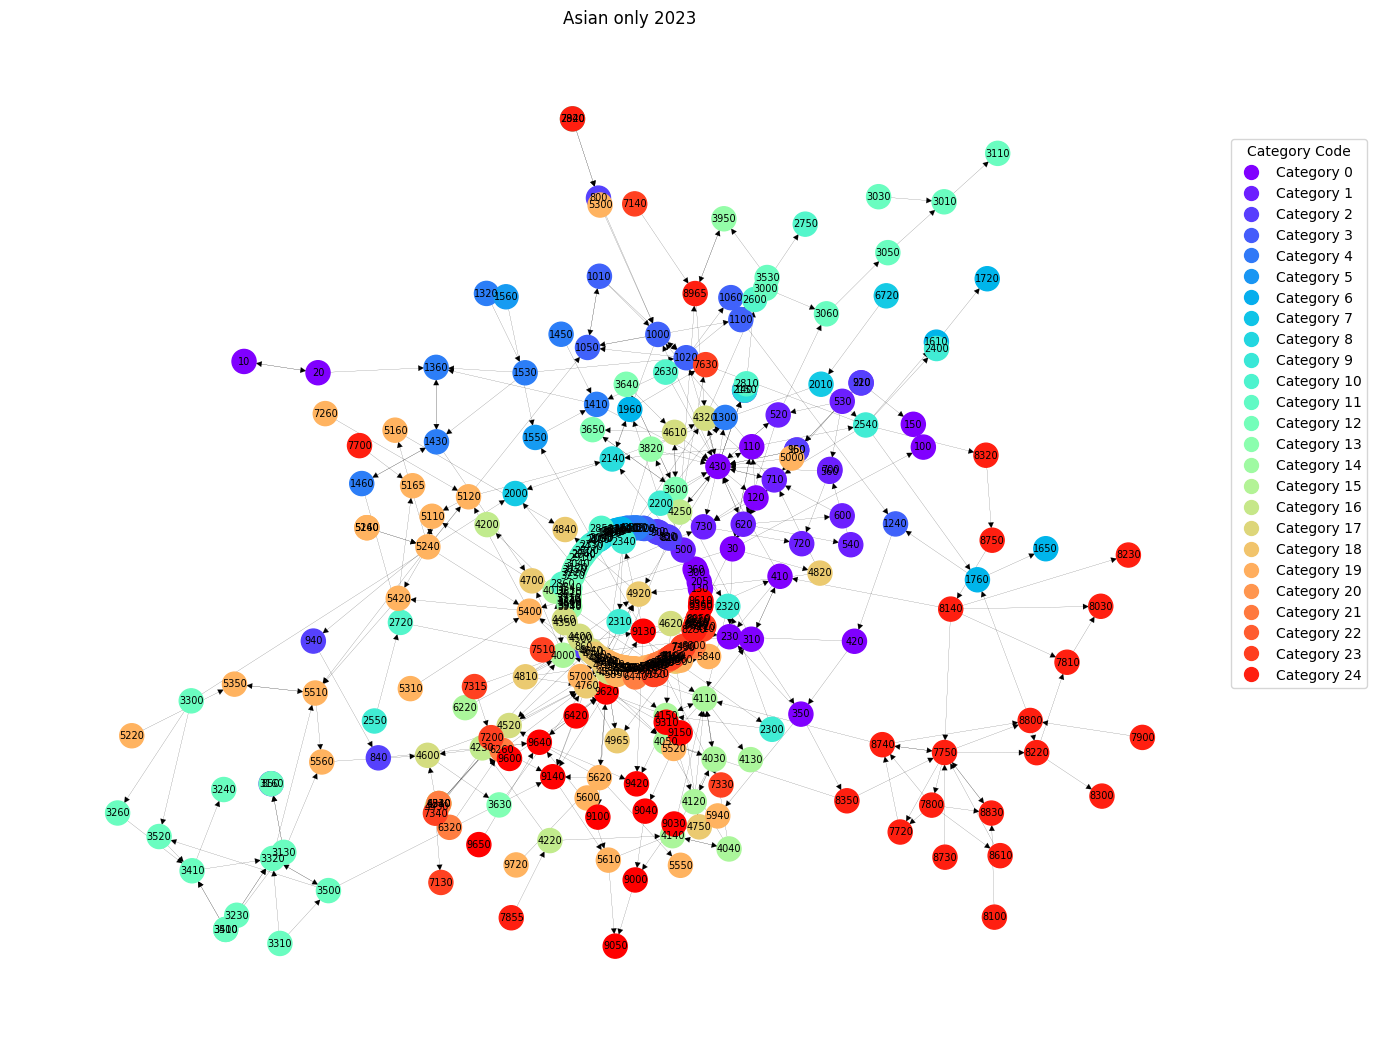

In [40]:
G_651 = create_graph(651, 2023)
plot_graph(G_651, 651)

In [41]:
centrality_651 = calc_centrality_measures(G_651)
top_centralities_651 = get_top_occ_centralities(centrality_651)
top_centralities_651

,degree,weighed_in_degree,weighed_out_degree,betweenness,closeness,eigenvector,pagerank
0,"Managers, nec (including Postmasters)","Managers, nec (including Postmasters)","Managers, nec (including Postmasters)","Managers, nec (including Postmasters)",Real Estate Brokers and Sales Agents,"Managers, nec (including Postmasters)",Retail Salespersons
1,Waiters and Waitresses,"Software Developers, Applications and Systems ...","Software Developers, Applications and Systems ...",Retail Salespersons,Retail Salespersons,"Combined Food Preparation and Serving Workers,...",Waiters and Waitresses
2,"Laborers and Freight, Stock, and Material Move...",Computer Scientists and Systems Analysts/Netwo...,"Laborers and Freight, Stock, and Material Move...",Food Service and Lodging Managers,Cashiers,Computer Scientists and Systems Analysts/Netwo...,"Managers, nec (including Postmasters)"
3,Cashiers,"Nursing, Psychiatric, and Home Health Aides",Computer Scientists and Systems Analysts/Netwo...,Waiters and Waitresses,Taxi Drivers and Chauffeurs,Real Estate Brokers and Sales Agents,Food Preparation Workers
4,Retail Salespersons,"Personal Appearance Workers, nec",Customer Service Representatives,Cashiers,"Combined Food Preparation and Serving Workers,...",Other Business Operations and Management Speci...,Food Service and Lodging Managers


In [42]:
centrality_wage_651 = combine_centrality_income(651, centrality_651)
centrality_wage_651

,OCC2010,Average_INCWAGE,occ_title,degree,weighted_degree,weighed_in_degree,weighed_out_degree,betweenness,closeness,eigenvector,pagerank
0,10.0,183269.336047,Chief executives and legislators/public admini...,0.006173,0.079659,0.067390,0.091448,0.000000,0.003086,1.689504e-20,0.002558
1,20.0,131750.106519,General and Operations Managers,0.009259,0.106812,0.095185,0.117982,0.001252,0.003086,1.689504e-20,0.003227
2,30.0,128470.451359,"Managers in Marketing, Advertising, and Public...",0.024691,0.294504,0.259341,0.328286,0.009404,0.071088,8.998834e-02,0.003157
3,100.0,60204.311144,Administrative Services Managers,0.003086,0.032402,0.066129,0.000000,0.000000,0.062292,2.763579e-02,0.001572
4,110.0,140729.583254,Computer and Information Systems Managers,0.021605,0.221539,0.178243,0.263135,0.022932,0.083981,1.660125e-01,0.003003
...,...,...,...,...,...,...,...,...,...,...,...
305,9420.0,30000.000000,"Transportation workers, nec",0.009259,0.085163,0.173806,0.000000,0.000000,0.073720,1.718393e-02,0.004142
306,9600.0,47105.633606,Industrial Truck and Tractor Operators,0.003086,0.022155,0.000000,0.043440,0.000000,0.000000,1.172329e-37,0.001052
307,9610.0,19392.388935,Cleaners of Vehicles and Equipment,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.172329e-37,0.001052
308,9620.0,38336.930362,"Laborers and Freight, Stock, and Material Move...",0.040123,0.441148,0.299463,0.577271,0.033810,0.099860,7.869692e-02,0.009588


* lowest average income: Jewelers and Precious Stone and Metal Workers; Television, Video; ... (0.00 $)
* highest average income: Podiatrists (400,000.00 $)

In [ ]:
centrality_wage_651.sort_values(by='weighed_out_degree')

,OCC2010,Average_INCWAGE,occ_title,degree,weighted_degree,weighed_in_degree,weighed_out_degree,betweenness,closeness,eigenvector,pagerank
252,7100.0,10500.000000,"Electrical and electronics repairers, transpor...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.160158e-37,0.001069
116,3120.0,400000.000000,Podiatrists,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.160158e-37,0.001069
118,3150.0,82540.599205,Occupational Therapists,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.160158e-37,0.001069
119,3160.0,91057.901697,Physical Therapists,0.003030,0.023522,0.048264,0.000000,0.000000,0.004040,1.918902e-34,0.001506
120,3220.0,61530.954452,Respiratory Therapists,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.160158e-37,0.001069
...,...,...,...,...,...,...,...,...,...,...,...
204,5240.0,52511.807057,Customer Service Representatives,0.033333,0.323681,0.147253,0.491412,0.012261,0.066844,6.449457e-03,0.006483
43,1000.0,103437.008278,Computer Scientists and Systems Analysts/Netwo...,0.027273,0.658521,0.794808,0.528952,0.007453,0.088148,2.224892e-01,0.011180
308,9620.0,38336.930362,"Laborers and Freight, Stock, and Material Move...",0.039394,0.438785,0.299463,0.571238,0.033037,0.098044,7.787990e-02,0.009604
45,1020.0,168435.039856,"Software Developers, Applications and Systems ...",0.027273,0.910444,0.874096,0.944999,0.018089,0.087915,1.957434e-01,0.011088


<Axes: >

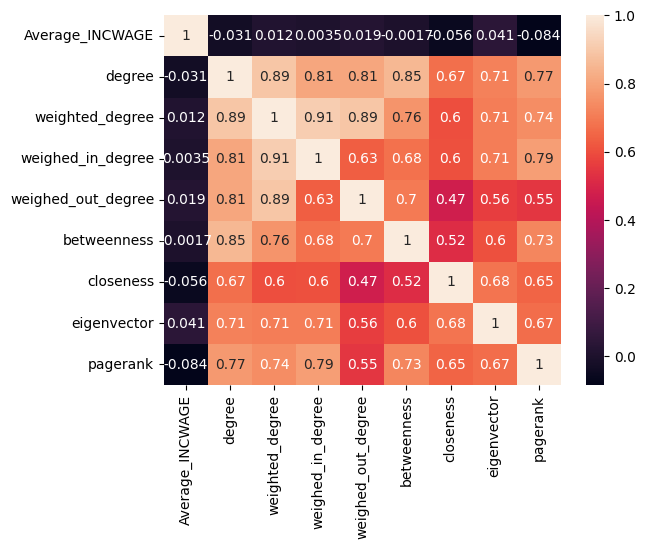

In [ ]:
corr = centrality_wage_651[['Average_INCWAGE', 'degree', 'weighted_degree','weighed_in_degree', 'weighed_out_degree', 'betweenness', 'closeness', 'eigenvector', 'pagerank']].corr()
sns.heatmap(corr, annot=True)

# Combine measures

In [ ]:
def get_most_central_occs(centrality_wage: pd.DataFrame, race, measures):
    most_central_occ = dict()
    highest_occ = []

    for measure in measures:
        if measure == 'closeness':
            highest_occ.append(centrality_wage.sort_values(by=measure).head(1)['occ_title'].item())
        else:
            highest_occ.append(centrality_wage.sort_values(by=measure).tail(1)['occ_title'].item())

    most_central_occ.update({race: highest_occ})

    return most_central_occ

In [ ]:
def get_least_central_occs(centrality_wage: pd.DataFrame, race, measures):
    least_central_occ = dict()
    lowest_occ = []

    for measure in measures:
        if measure == 'closeness':
            lowest_occ.append(centrality_wage.sort_values(by=measure).tail(1)['occ_title'].item())
        else:
            lowest_occ.append(centrality_wage.sort_values(by=measure).head(1)['occ_title'].item())

    least_central_occ.update({race: lowest_occ})

    return least_central_occ

In [ ]:
measures = ['degree', 'weighted_degree','weighed_in_degree', 'weighed_out_degree', 'betweenness', 'closeness', 'eigenvector', 'pagerank']

most_central_occ = get_most_central_occs(centrality_wage_100, 100, measures)
most_central_occ.update(get_most_central_occs(centrality_wage_200, 200, measures))
most_central_occ.update(get_most_central_occs(centrality_wage_300, 300, measures))
most_central_occ.update(get_most_central_occs(centrality_wage_801, 801, measures))
most_central_occ.update(get_most_central_occs(centrality_wage_651, 651, measures))

In [ ]:
least_central_occ = get_least_central_occs(centrality_wage_100, 100, measures)
least_central_occ.update(get_least_central_occs(centrality_wage_200, 200, measures))
least_central_occ.update(get_least_central_occs(centrality_wage_300, 300, measures))
least_central_occ.update(get_least_central_occs(centrality_wage_801, 801, measures))
least_central_occ.update(get_least_central_occs(centrality_wage_651, 651, measures))

In [ ]:
most_central_occ = pd.DataFrame.from_dict(most_central_occ, orient='index')
most_central_occ.columns = measures

least_central_occ = pd.DataFrame.from_dict(least_central_occ, orient='index')
least_central_occ.columns = measures

In [ ]:
least_central_occ

,degree,weighted_degree,weighed_in_degree,weighed_out_degree,betweenness,closeness,eigenvector,pagerank
100,Prepress Technicians and Workers,Tire Builders,"Electrical and electronics repairers, transpor...",NIU,NIU,NIU,Prepress Technicians and Workers,Food Cooking Machine Operators and Tenders
200,"Transportation workers, nec",First-Line Supervisors of Construction Trades ...,Locomotive Engineers and Operators,NIU,NIU,"Managers, nec (including Postmasters)",Helpers--Production Workers,Occupational Therapy Assistants and Aides
300,Chief executives and legislators/public admini...,Chief executives and legislators/public admini...,Chief executives and legislators/public admini...,Chief executives and legislators/public admini...,Chief executives and legislators/public admini...,"Shipping, Receiving, and Traffic Clerks",Chief executives and legislators/public admini...,Chief executives and legislators/public admini...
801,"Pipelayers, Plumbers, Pipefitters, and Steamfi...",Electricians,Chief executives and legislators/public admini...,NIU,Chief executives and legislators/public admini...,Receptionists and Information Clerks,Chief executives and legislators/public admini...,Chief executives and legislators/public admini...
651,Occupational Therapy Assistants and Aides,Mining Machine Operators,First-Line Supervisors of Police and Detectives,NIU,Chief executives and legislators/public admini...,Real Estate Brokers and Sales Agents,Fishing and hunting workers,"Medical, Dental, and Ophthalmic Laboratory Tec..."


In [ ]:
centrality_wage_801[centrality_wage_801['OCC2010'] == 430.0]

,OCC2010,Average_INCWAGE,occ_title,degree,weighted_degree,weighed_in_degree,weighed_out_degree,betweenness,closeness,eigenvector,pagerank
14,430.0,87825.0,"Managers, nec (including Postmasters)",0.018634,0.391996,0.245389,0.318676,0.000155,0.008282,8.709251e-08,0.006155


In [ ]:
centrality_wage_100[centrality_wage_100['OCC2010'] == 430.0]

,OCC2010,Average_INCWAGE,occ_title,degree,weighted_degree,weighed_in_degree,weighed_out_degree,betweenness,closeness,eigenvector,pagerank
19,430.0,91239.959147,"Managers, nec (including Postmasters)",0.342043,1.0,1.0,1.0,0.121808,0.436065,0.295903,0.021086


In [ ]:
centrality_wage_200[centrality_wage_200['OCC2010'] == 430.0]

,OCC2010,Average_INCWAGE,occ_title,degree,weighted_degree,weighed_in_degree,weighed_out_degree,betweenness,closeness,eigenvector,pagerank
19,430.0,88297.025641,"Managers, nec (including Postmasters)",0.120968,1.0,1.0,0.976196,0.078924,0.194797,0.27041,0.028371


In [ ]:
centrality_wage_300[centrality_wage_300['OCC2010'] == 430.0]

,OCC2010,Average_INCWAGE,occ_title,degree,weighted_degree,weighed_in_degree,weighed_out_degree,betweenness,closeness,eigenvector,pagerank
16,430.0,116999.086957,"Managers, nec (including Postmasters)",0.025862,0.410331,0.100781,0.582544,0.000205,0.00431,0.001833,0.005952


In [ ]:
centrality_wage_651[centrality_wage_651['OCC2010'] == 430.0]

,OCC2010,Average_INCWAGE,occ_title,degree,weighted_degree,weighed_in_degree,weighed_out_degree,betweenness,closeness,eigenvector,pagerank
19,430.0,125577.996016,"Managers, nec (including Postmasters)",0.09697,1.0,1.0,1.0,0.086244,0.099514,0.320212,0.021633
